<link rel="stylesheet" href="fonts/css/font-awesome.min.css">
[А. Л.](https://capissimo.github.io/pythonfordatascience), 2017

https://capissimo.github.io/pythonfordatascience

## Глава 2. Статистический вывод

### Содержание

- [Обследование данных](#Обследование-данных)
- [Визуализация времени задержки](#Визуализация-времени-задержки)
- [Экспоненциальное распределение](#Экспоненциальное-распределение)
- [Центральная предельная теорема](#Центральная-предельная-теорема)
- [Стандартная ошибка](#Стандартная-ошибка)
- [Выборочные и генеральные совокупности](#Выборочные-и-генеральные-совокупности)
- [Визуализация разных генеральных совокупностей](#Визуализация-разных-генеральных-совокупностей)
- [Проверка обновленного дизайна веб-сайта](#Проверка-обновленного-дизайна-веб-сайта)
- [t-статистика](#t-статистика)
- [Выполнение t-теста](#Выполнение-t-теста)
- [Одновыборочный t-тест](#Одновыборочный-t-тест)
- [Взятие повторных выборок](#Взятие-повторных-выборок)
- [Проверка многочисленных вариантов дизайна веб-сайта](#Проверка-многочисленных-вариантов-дизайна-веб-сайта)
- [Поправка Бонферрони](#Поправка-Бонферрони)
- [F-распределение](#F-распределение)
- [F-статистика](#F-статистика)
- [Выполнение F-теста](#Выполнение-F-теста)
- [Размер эффекта](#Размер-эффекта)

<a name="home"></a>

In [146]:
# -*- coding: utf-8 -*-

# Системные библиотеки

import scipy as sp
import pandas as pd    
from scipy import stats

# Графические настройки 

import matplotlib.pyplot as plt
DPI = 300   
from matplotlib import rcParams
rcParams['font.family']     = 'sans-serif'
rcParams['font.sans-serif'] = ['Ubuntu Condensed']
rcParams['figure.figsize']  = (5, 4)
rcParams['legend.fontsize'] = 10

def saveplot(dest):
    plt.tight_layout()
    plt.savefig('images/' + dest, dpi=DPI)  

### Обследование данных

In [139]:
def load_data(fname):
    '''Загрузка данных из файла fname'''
    return pd.read_csv('data/ch02/' + fname, '\t')  

In [69]:
def ex_2_1():
    '''Загрузка данных времени задержки на веб-сайте'''
    return load_data('dwell-times.tsv')[0:5:]  # как вариант, head()
    
ex_2_1()

,date,dwell-time
0,2015-01-01T00:03:43Z,74
1,2015-01-01T00:32:12Z,109
2,2015-01-01T01:52:18Z,88
3,2015-01-01T01:54:30Z,17
4,2015-01-01T02:09:24Z,11


### Визуализация времени задержки

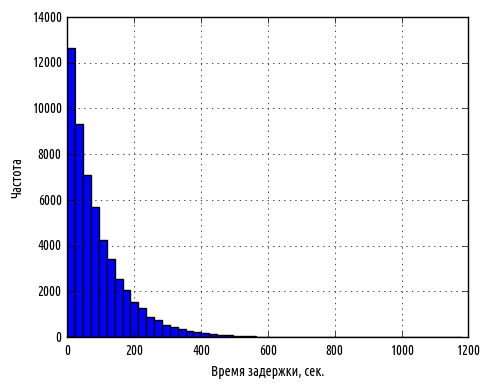

In [113]:
def ex_2_2():
    '''Визуализация времени задержки'''
    load_data('dwell-times.tsv')['dwell-time'].hist(bins=50)
    plt.xlabel('Время задержки, сек.')
    plt.ylabel('Частота')
    #saveplot('ex_2_2.png')  
    plt.show()    
    
ex_2_2()

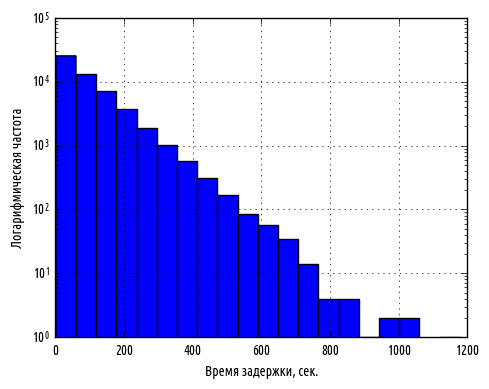

In [145]:
def ex_2_3():
    '''Визуализация времени задержки
       на полулогарифмическом графике'''
    load_data('dwell-times.tsv')['dwell-time'].plot.hist(bins=20, logy=True, grid=True)
    plt.xlabel('Время задержки, сек.')
    plt.ylabel('Логарифмическая частота')
    #saveplot('ex_2_3.png')  
    plt.show()    
    
ex_2_3()

### Экспоненциальное распределение

In [72]:
def ex_2_4():
    '''Показать сводные статистики набора данных,
       подчиняющегося экспоненциональному распределению'''
    ts = load_data('dwell-times.tsv')['dwell-time']
    print('Среднее:', ts.mean())    
    print('Медиана:', ts.median())
    print('СКО:    ', ts.std())
    
ex_2_4()

Среднее: 93.2014074074
Медиана: 64.0
СКО:     93.9697240252


*Распределение среднесуточных значений*

In [140]:
# Определение служебных функций по обработке дат

def with_parsed_date(df):
    '''Привести поле date к типу date-time'''
    df['date'] = pd.to_datetime(df['date'], errors='ignore')
    return df

def filter_weekdays(df): 
    '''Отфильтровать по будним дням'''
    return df[df['date'].index.dayofweek < 5]  # понедельник..пятница

def mean_dwell_times_by_date(df):
    '''Среднесуточные времена задержки'''
    df.index = with_parsed_date(df)['date']
    return df.resample('D').mean()  # перегруппировать  

def daily_mean_dwell_times(df):
    '''Средние времена задержки с фильтрацией - только по будним дням'''
    df.index = with_parsed_date(df)['date']
    df = filter_weekdays(df)
    return df.resample('D').mean() 

In [74]:
def ex_2_5():
    '''Распределение значений в будние дни'''
    df  = load_data('dwell-times.tsv')    
    means = daily_mean_dwell_times(df)
    print('Среднее: %f' % (means.mean()))    
    print('Медиана: %f' % (means.median()))
    print('СКО:     %f' % (means.std()))
    
ex_2_5()

Среднее: 90.210429
Медиана: 90.136612
СКО:     3.722343


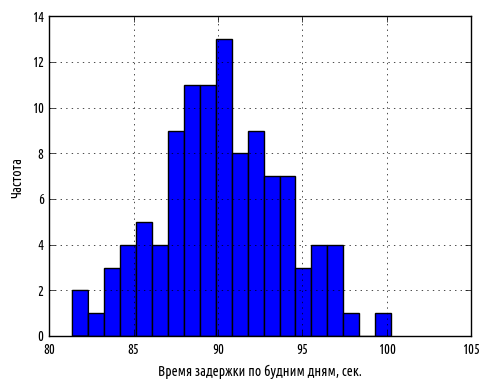

In [116]:
def ex_2_6():
    '''Построить гистограмму значений 
       времени задержки в будние дни'''
    df = load_data('dwell-times.tsv')
    daily_mean_dwell_times(df)['dwell-time'].hist(bins=20)
    plt.xlabel('Время задержки по будним дням, сек.')
    plt.ylabel('Частота')
    #saveplot('ex_2_6.png')  
    plt.show()    
    
ex_2_6()

### Центральная предельная теорема

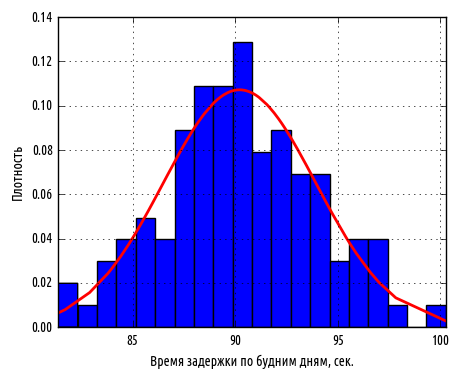

In [143]:
def ex_2_7():
    '''Подгонка нормальной кривой поверх гистограммы'''
    df = load_data('dwell-times.tsv')
    means = daily_mean_dwell_times(df)['dwell-time'].dropna() 
    ax = means.hist(bins=20, normed=True)
    xs = sorted(means)    # корзины
    df = pd.DataFrame( {0:xs, 
                        1: stats.norm.pdf(xs, means.mean(), means.std())} )
    df.plot(0, 1, linewidth=2, color='r', legend=None, ax=ax)
    plt.xlabel('Время задержки по будним дням, сек.')
    plt.ylabel('Плотность')
    plt.grid(True)
    #saveplot('ex_2_7.png')  
    plt.show()
    
ex_2_7()

### Стандартная ошибка

In [79]:
# Определение функции стандартной ошибки среднего

def variance(xs):
    '''Вычисление дисперсии,
       несмещенная дисперсия при n <= 30'''
    x_hat = xs.mean() 
    n = len(xs)
    n = n-1 if n in range(1, 30) else n  
    square_deviation = lambda x : (x - x_hat) ** 2 
    return sum( map(square_deviation, xs) ) / n

def standard_deviation(xs):
    '''Вычисление стандартного отклонения'''
    return sp.sqrt(variance(xs))

def standard_error(xs):
    '''Вычисление стандартной ошибки'''
    return standard_deviation(xs) / sp.sqrt(len(xs))

### Выборочные и генеральные совокупности

In [80]:
def ex_2_8(): 
    '''Вычислить стандартную ошибку 
       средних значений за определенный день'''
    may_1 = '2015-05-01'
    df = with_parsed_date( load_data('dwell-times.tsv') )  
    filtered = df.set_index( ['date'] )[may_1]
    se = standard_error( filtered['dwell-time'] )
    print('Стандартная ошибка (СОШ):', se)

ex_2_8()

Стандартная ошибка (СОШ): 3.62734027309


In [81]:
def confidence_interval(p, xs):
    '''Доверительный интервал'''
    x_hat = xs.mean()
    se = standard_error(xs)
    '''критическое значение z
    Критическое значение z - это число стандартных отклонений, на которые 
    нужно отойти от среднего значения нормального распределения, чтобы захватить 
    долю данных, связанную с нужным доверительным интервалом.'''
    z_crit = stats.norm.ppf(1 - (1-p) / 2)  #q=0.975 -> 1.96
    return [x_hat - z_crit * se, x_hat + z_crit * se]

In [82]:
def ex_2_9():
    '''Вычислить доверительный интервал 
       для данных за определенный день'''
    may_1 = '2015-05-01'
    df    = with_parsed_date( load_data('dwell-times.tsv') )  
    filtered = df.set_index( ['date'] )[may_1]
    ci = confidence_interval(0.95, filtered['dwell-time'])
    print('Доверительный интервал (ДИ): ', ci)
    
ex_2_9()

Доверительный интервал (ДИ):  [83.53415272762004, 97.753065317492741]


*Сравнение выборок*

In [83]:
def ex_2_10():
    '''Сводные статистики данных, полученных 
       в результате вирусной кампании'''
    ts = load_data('campaign-sample.tsv')['dwell-time']     
    print('n:      ', ts.count())
    print('Среднее:', ts.mean())
    print('Медиана:', ts.median())
    print('СКО:    ', ts.std())
    print('СОШ:    ', standard_error(ts))    

ex_2_10()

n:       300
Среднее: 130.22
Медиана: 84.0
СКО:     136.133707144
СОШ:     7.84657283999


In [84]:
def ex_2_11():
    '''Доверительный интервал данных,
       полученных в результате вирусной кампании'''
    ts = load_data('campaign-sample.tsv')['dwell-time']     
    print('ДИ:', confidence_interval(0.95, ts))

ex_2_11()    

ДИ: [114.84099983154137, 145.59900016845864]


*Смещение*

In [85]:
'''Проверка даты''' 
# будние дни: 0..4, выходные дни: 5-6
d = pd.to_datetime('2015 6 6') 
d.weekday() in [5,6]

True

### Визуализация разных генеральных совокупностей

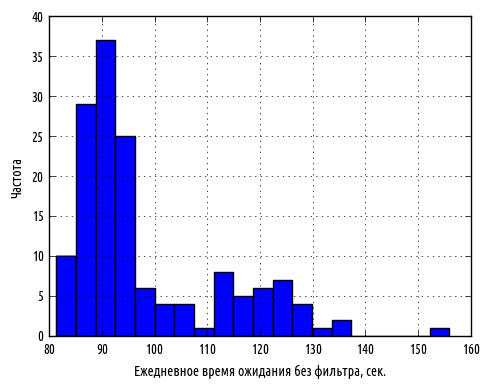

In [118]:
def ex_2_12(): 
    '''Построить график времени ожидания 
       по всем дням без фильтра'''
    df = load_data('dwell-times.tsv')
    means = mean_dwell_times_by_date(df)['dwell-time']
    means.hist(bins=20)
    plt.xlabel('Ежедневное время ожидания без фильтра, сек.')
    plt.ylabel('Частота')
    #saveplot('ex_2_12.png') 
    plt.show()     

ex_2_12()

In [87]:
def ex_2_13():
    '''Сводные статистики данных,
       отфильтрованных только по выходным дням'''
    df = with_parsed_date( load_data('dwell-times.tsv') )
    df.index = df['date']
    df = df[df['date'].index.dayofweek > 4]   # суббота-воскресенье
    weekend_times = df['dwell-time']
  
    print('n:      ', weekend_times.count())
    print('Среднее:', weekend_times.mean())
    print('Медиана:', weekend_times.median())
    print('СКО:    ', weekend_times.std())
    print('СОШ:    ', standard_error(weekend_times))        
    
ex_2_13()

n:       5860
Среднее: 117.786860068
Медиана: 81.0
СКО:     120.652340772
СОШ:     1.57597703625


### Проверка обновленного дизайна веб-сайта 

*Выполнение z-теста*

In [88]:
def pooled_standard_error(a, b, unbias=False):
    '''Объединенная стандартная ошибка'''
    std1 = a.std(ddof=0) if unbias==False else a.std()  # ddof=0 = смещенное значение
    std2 = b.std(ddof=0) if unbias==False else b.std()
    x = std1 ** 2 / a.count()
    y = std2 ** 2 / b.count()
    return sp.sqrt(x + y)    

def z_stat(a, b, unbias=False):
    '''z-статистика'''
    return (a.mean() - b.mean()) / pooled_standard_error(a, b, unbias)    

def z_test(a, b): 
    '''z-тест'''
    # ИФР нормального распределения
    return stats.norm.cdf([ z_stat(a, b) ])

In [89]:
def ex_2_14():
    '''Сравнение работоспособности двух вариантов
       дизайна веб-сайта на основе z-теста'''
    groups = load_data('new-site.tsv').groupby('site')['dwell-time']
    a = groups.get_group(0)
    b = groups.get_group(1) 
    
    print('a n: ', a.count())
    print('b n: ', b.count())
    print('z-статистика:', z_stat(a, b))
    print('p-значение:', z_test(a, b))
    
ex_2_14()

a n:  284
b n:  16
z-статистика: -1.64674381801
p-значение: [ 0.04980536]


### t-статистика

In [90]:
def pooled_standard_error_t(a, b):
    '''Объединенная стандартная ошибка для t-теста'''
    return sp.sqrt(standard_error(a) ** 2 + 
                   standard_error(b) ** 2) 

In [91]:
t_stat = z_stat

def ex_2_15():
    '''Вычисление t-статистики 
       двух вариантов дизайна веб-сайта'''
    groups = load_data('new-site.tsv').groupby('site')['dwell-time']
    a = groups.get_group(0)
    b = groups.get_group(1)    
    return t_stat(a, b)
    
ex_2_15()

-1.6467438180091214

### Выполнение t-теста

In [92]:
def t_test(a, b):
    '''Выполнение проверки на основе t-теста'''
    df = len(a) + len(b) - 2
    # http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.t.html
    return stats.t.sf([ abs(t_stat(a, b)) ], df)      # функция выживания (1-cdf иногда точнее)

In [93]:
def ex_2_16():
    '''Сравнение работоспособности двух вариантов 
       дизайна веб-сайта на основе t-теста'''
    groups = load_data('new-site.tsv').groupby('site')['dwell-time']
    a = groups.get_group(0)
    b = groups.get_group(1)   
    return t_test(a, b)

ex_2_16()

array([ 0.05033241])

In [94]:
def t_test_verbose(a, sample2=None, mean=None, fn=None):
    '''Служебная функция с подробной информацией 
       результата t-теста'''
    abar = a.mean()
    avar = a.var(ddof=1)  # несмещенное значение
    na = a.size
    adof = na - 1
    conf_int = stats.t.interval(0.95, len(a)-1, 
                                loc=sp.mean(a), scale=stats.sem(a))

    if type(a) == type(sample2):
        bbar = sample2.mean()
        bvar = sample2.var(ddof=1)
        nb = sample2.size
        bdof = nb - 1

        dof = (avar/na + bvar/nb)**2 /   \
              (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
        return {'p-значение'            : 
                   fn(a, sample2, equal_var=False).pvalue,  #  выполняет t-тест Уэлша   
                'степени свободы df'    : dof,  #t_test( a, b ),   
                'доверительный интервал': conf_int,         # conf-int [-78.9894629402365 10.890871390940724]
                'n1'           : a.count(),
                'n2'           : sample2.count(),
                'среднее x'    : a.mean(),
                'среднее y'    : sample2.mean(),
                'дисперсия x'  : a.var(),
                'дисперсия y'  : sample2.var(),
                't-статистика' : fn( a, sample2, equal_var=False ).statistic} 
    else:
        dof = (avar/na) / (avar/(na*adof))
        return {'p-значение'            : fn(a, mean).pvalue,    
                'степени свободы df'    : dof,    
                'доверительный интервал': conf_int, 
                'n1'                    : a.count(),
                'среднее x'             : a.mean(),
                'дисперсия x'           : a.var(),
                't-статистика'          : fn(a, mean).statistic} 

*Двухсторонние тесты*

In [95]:
def ex_2_17():
    '''Двухсторонний t-тест'''
    groups = load_data('new-site.tsv').groupby('site')['dwell-time']
    a = groups.get_group(0)
    b = groups.get_group(1)    
    return t_test_verbose(a, sample2=b, fn=stats.ttest_ind)  # выполняет t-тест Уэлша

ex_2_17()

{'n1': 284,
 'n2': 16,
 'p-значение': 0.12756432502462475,
 't-статистика': -1.5985205593851322,
 'дисперсия x': 10463.941024237296,
 'дисперсия y': 6669.8666666666668,
 'доверительный интервал': (76.002631987995969, 99.898776462708256),
 'среднее x': 87.950704225352112,
 'среднее y': 122.0,
 'степени свободы df': 17.761382349686098}

### Одновыборочный t-тест

In [96]:
def ex_2_18():
    '''Одновыборочный t-тест'''
    groups = load_data('new-site.tsv').groupby('site')['dwell-time']
    b = groups.get_group(1) 
    return t_test_verbose(b, mean=90, fn=stats.ttest_1samp)  

ex_2_18()

{'n1': 16,
 'p-значение': 0.13789520958229415,
 't-статистика': 1.5672973291495713,
 'дисперсия x': 6669.8666666666668,
 'доверительный интервал': (78.481527665903897, 165.51847233409609),
 'среднее x': 122.0,
 'степени свободы df': 15.0}

### Взятие повторных выборок

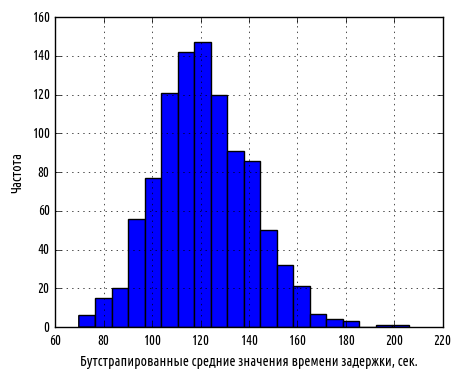

In [125]:
def ex_2_19():
    '''Построение графика синтетических времен задержки 
       путем извлечения бутстрап-выборок'''
    groups = load_data('new-site.tsv').groupby('site')['dwell-time']
    b = groups.get_group(1) 
    xs = [b.sample(len(b), replace=True).mean() for _ in range(1000)] 
    #?xs = map(sp.mean, lambda x: sp.random.choice(x, (1000, len(x)), replace=True))
    pd.Series(xs).hist(bins=20)
    plt.xlabel('Бутстрапированные средние значения времени задержки, сек.')
    plt.ylabel('Частота') 
    #saveplot('ex_2_19.png') 
    plt.show() 
    
ex_2_19()

### Проверка многочисленных вариантов дизайна веб-сайта

*Вычисление выборочных средних*

In [98]:
def ex_2_20():
    '''Выборочные средние значения 
       20 разных вариантов дизайна веб-сайта'''
    df = load_data('multiple-sites.tsv')
    return df.groupby('site').aggregate(sp.mean)

ex_2_20()

,dwell-time
site,
0,79.851064
1,106.000000
2,88.229167
3,97.479167
4,94.333333
5,102.333333
6,144.192982
7,123.367347
8,94.346939


In [99]:
import itertools

def ex_2_21():
    '''Проверка вариантов дизайна веб-сайта на основе t-тест 
       по принципу "каждый с каждым"'''
    groups = load_data('multiple-sites.tsv').groupby('site')
    alpha = 0.05
    
    pairs = [list(x)   # найти сочетания из n по k
             for x in itertools.combinations(range(len(groups)), 2)]  

    for pair in pairs:
        gr, gr2 = groups.get_group( pair[0] ), groups.get_group( pair[1] )
        site_a, site_b = pair[0], pair[1]
        a, b = gr['dwell-time'], gr2['dwell-time']  
        p_val = stats.ttest_ind(a, b, equal_var = False).pvalue  
        if p_val < alpha: 
            print('Варианты веб-сайта %i и %i значимо различаются: %f' 
                  % (site_a, site_b, p_val))
    
ex_2_21()

Варианты веб-сайта 0 и 6 значимо различаются: 0.005534
Варианты веб-сайта 0 и 7 значимо различаются: 0.035068
Варианты веб-сайта 0 и 10 значимо различаются: 0.006881
Варианты веб-сайта 0 и 15 значимо различаются: 0.046591
Варианты веб-сайта 2 и 6 значимо различаются: 0.018257
Варианты веб-сайта 2 и 10 значимо различаются: 0.029948
Варианты веб-сайта 3 и 6 значимо различаются: 0.038758
Варианты веб-сайта 4 и 6 значимо различаются: 0.027908
Варианты веб-сайта 4 и 10 значимо различаются: 0.046962
Варианты веб-сайта 6 и 8 значимо различаются: 0.039915
Варианты веб-сайта 6 и 9 значимо различаются: 0.026231
Варианты веб-сайта 6 и 11 значимо различаются: 0.035796
Варианты веб-сайта 6 и 12 значимо различаются: 0.004079
Варианты веб-сайта 6 и 13 значимо различаются: 0.024710
Варианты веб-сайта 6 и 14 значимо различаются: 0.002538
Варианты веб-сайта 6 и 16 значимо различаются: 0.033198
Варианты веб-сайта 6 и 17 значимо различаются: 0.004953
Варианты веб-сайта 6 и 18 значимо различаются: 0.030166

In [100]:
def ex_2_22():
    '''Проверка вариантов дизайна веб-сайта на основе t-теста 
       против исходного (0)'''
    groups = load_data('multiple-sites.tsv').groupby('site')
    alpha = 0.05 
    baseline = groups.get_group(0)['dwell-time']
    for site_a in range(1, len(groups)):
        a = groups.get_group( site_a )['dwell-time']
        p_val = stats.ttest_ind(a, baseline, equal_var = False).pvalue 
        if p_val < alpha: 
            print('Вариант %i веб-сайта значимо отличается от исходного: %f' 
                  % (site_a, p_val))
    
ex_2_22()

Вариант 6 веб-сайта значимо отличается от исходного: 0.005534
Вариант 7 веб-сайта значимо отличается от исходного: 0.035068
Вариант 10 веб-сайта значимо отличается от исходного: 0.006881
Вариант 15 веб-сайта значимо отличается от исходного: 0.046591


### Поправка Бонферрони

In [101]:
def ex_2_23():
    '''Проверка вариантов дизайна веб-сайта на основе t-теста 
       против исходного (0) с поправкой Бонферрони'''
    groups = load_data('multiple-sites.tsv').groupby('site')
    alpha = 0.05 / len(groups)
    baseline = groups.get_group(0)['dwell-time']
    for site_a in range(1, len(groups)):
        a = groups.get_group(site_a)['dwell-time']
        p_val = stats.ttest_ind(a, baseline, equal_var = False).pvalue 
        if p_val < alpha: 
            print('Вариант %i веб-сайта отличается от исходного: %f' 
                  % (site_a, p_val))
    
ex_2_23()

### F-распределение

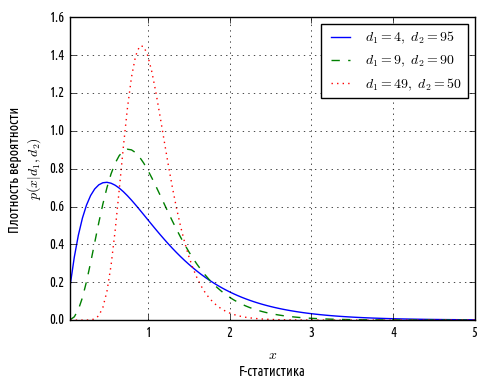

In [148]:
def ex_2_Fisher():
    '''Визуализация разных F-распределений на графике'''
    mu = 0
    d1_values, d2_values = [4, 9, 49], [95, 90, 50]
    linestyles = ['-', '--', ':', '-.']
    x = sp.linspace(0, 5, 101)[1:] 
    ax = None
    for (d1, d2, ls) in zip(d1_values, d2_values, linestyles):
        dist = stats.f(d1, d2, mu)
        df  = pd.DataFrame( {0:x, 1:dist.pdf(x)} )   
        ax = df.plot(0, 1, ls=ls, 
                     label=r'$d_1=%i,\ d_2=%i$' % (d1,d2), ax=ax)

    plt.xlabel('$x$\nF-статистика')
    plt.ylabel('Плотность вероятности \n$p(x|d_1, d_2)$')
    plt.grid(True)
    #saveplot('ex_2_Fisher.png') 
    plt.show()

ex_2_Fisher()

### F-статистика

In [103]:
def ssdev(xs):
    '''Сумма квадратов отклонений между 
       каждым элементом и средним по выборке'''
    x_hat = xs.mean() 
    square_deviation = lambda x : (x - x_hat) ** 2 
    return sum( map(square_deviation, xs) ) 

### Выполнение F-теста

In [104]:
def f_test(groups):
    '''Проверка на основе F-теста'''
    m, n = len(groups), sum(groups.count())
    df1, df2 = m - 1, n - m 
    ssw = sum( groups.apply(lambda g: ssdev(g)) )  # внутригрупповая сумма квадратов отклонений
    sst = ssdev( df['dwell-time'] )                # полная сумма квадратов по всему набору
    ssb = sst - ssw                                # межгрупповая сумма квадратов отклонений
    msb = ssb / df1                                # усредненная межгрупповая
    msw = ssw / df2                                # усредненная внутригрупповая
    f_stat = msb / msw
    return stats.f.sf(f_stat, df1, df2)            # функция выживания (иногда точнее, чем 1-cdf )

In [105]:
def ex_2_24():
    '''Проверка вариантов дизайна веб-сайта на основе F-теста'''
    df = load_data('multiple-sites.tsv')
    groups = df.groupby('site')['dwell-time']
    return f_test(groups)
   
ex_2_24()

0.014031745203658217

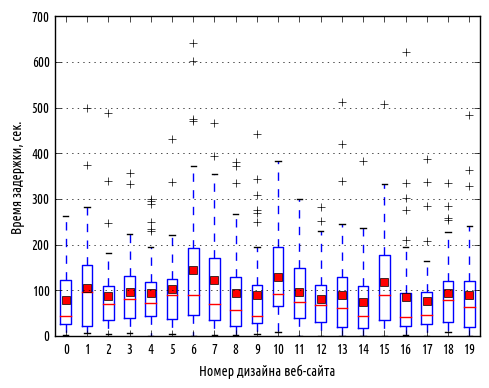

In [131]:
def ex_2_25():
    '''Визуализация распределений всех вариантов 
       дизайна веб-сайта на одной коробчатой диаграмме'''
    df = load_data('multiple-sites.tsv')
    df.boxplot(by='site', showmeans=True)
    plt.xlabel('Номер дизайна веб-сайта')
    plt.ylabel('Время задержки, сек.')
    plt.title('')
    plt.suptitle('')
    plt.gca().xaxis.grid(False)
    #saveplot('ex_2_25.png') 
    plt.show()

ex_2_25()

In [107]:
def ex_2_26():
    '''Проверка вариантов 0 и 10 дизайна веб-сайта на основе F-теста'''
    df = load_data('multiple-sites.tsv')
    groups   = df.groupby('site')['dwell-time']
    site_0   = groups.get_group(0) 
    site_10  = groups.get_group(10)
    _, p_val = stats.ttest_ind(site_0, site_10, equal_var=False)
    return p_val

ex_2_26()

0.0068811940138903786

In [108]:
def ex_2_27():
    '''Проверка вариантов 0 и 6 дизайна веб-сайта на основе F-теста'''
    df = load_data('multiple-sites.tsv')
    groups   = df.groupby('site')['dwell-time']
    site_0   = groups.get_group(0) 
    site_6   = groups.get_group(6)
    _, p_val = stats.ttest_ind(site_0, site_6, equal_var=False)
    return p_val
    
ex_2_27()

0.005534181712508717

### Размер эффекта

*Интервальный индекс d Коэна*

In [109]:
def pooled_standard_deviation(a, b):
    '''Объединенное стандартное отклонение 
       (не объединенная стандартная ошибка)'''
    return sp.sqrt( standard_deviation(a) ** 2 +
                    standard_deviation(b) ** 2)

In [110]:
def ex_2_28():
    '''Вычисление интервального индекса d Коэна 
       для варианта дизайна веб-сайта под номером 6'''
    df = load_data('multiple-sites.tsv')
    groups = df.groupby('site')['dwell-time']
    a      = groups.get_group(0)
    b      = groups.get_group(6)
    return (b.mean() - a.mean()) / pooled_standard_deviation(a, b)

ex_2_28()

0.38913648705499848

<a href="#home"><i class="fa fa-home fa-fw"></i></a><br><br>